### Requirements

#### Importing required libraries and modules

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

sns.set_style('darkgrid')

In [164]:
census_path = r'E:\Projects\Healthcare Census\Data\census_2011.csv'
housing_path = r'E:\Projects\Healthcare Census\Data\housing.csv'
hospitals_path = r'E:\Projects\Healthcare Census\Data\hospitals.csv'
government_path = r'E:\Projects\Healthcare Census\Data\government_hospitals.csv'

geo_mapping = r'E:\Projects\Healthcare Census\Geopandas\india-polygon.shp'

In [165]:
census_df = pd.read_csv(census_path)
housing_df = pd.read_csv(housing_path)
hospitals_df = pd.read_csv(hospitals_path)
government_df = pd.read_csv(government_path)

map_df = gpd.read_file(geo_mapping)

#### Data Preprocessing Class

In [166]:
class Preprocessing:
    def __init__(self, df):
        self.df = df.copy()
    
    def dfInfo(self):
        '''Prints basic information such as shape, columns with missing values, etc about any input dataframe.'''
        print(self.df.shape)
        print('='*50)
        print(self.df.info())
        print('='*50)
        # null_cols = [col for col in df.columns if df[col].isnull().sum() != 0]
        # print(f'Columns with missing values: {null_cols}')

    def select_columns(self, columns):
        '''Creates a subset dataframe of the original dataframe as per the columns passed to this function.'''
        self.df = self.df[columns]
        # return self.df
    
    def rename_columns(self, columns):
        '''Renames the columns of the dataframe as per the columns passed to it.'''
        self.df.rename(columns=columns, inplace=True)
        # return self.df
    
    def uniform_state_ut(self, col):
        '''Modifies and adds uniformity to State/UT column values.'''
        self.df[col] = self.df[col].str.title().replace(['And ', '& '], 'and ', regex=True)
        self.df[col] = self.df[col].str.title().replace('\*', '', regex=True)

        # return self.df

    def replace_state(self, state, districts):
        '''Changing the state names as per the district lists.'''
        self.df.loc[self.df['District'].isin(districts), 'State/UT'] = state

    def modify_state(self, prev_state, new_state):
        '''Modify the name of the state with a new name.'''
        self.df = self.df.replace(prev_state, new_state)

    def null_percent(self):
        '''Checks the null percentage for each column in the dataframe.'''
        null_percents = self.df.isnull().sum() * 100 / len(self.df)
        null_percents = null_percents.reset_index()
        null_percents.columns = ['Columns', 'Null_Percent']
        null_percents = null_percents.sort_values(by=['Null_Percent'],
                                                    ascending=False)
        return null_percents
    
    def fill_nulls(self, total, rest_cols):
        '''Fills the null values using other columns.'''
        self.df[total] = self.df[total].fillna(self.df[rest_cols].sum(axis=1, 
                                                                      skipna=False))
        for col in rest_cols:
            copy_cols = [c for c in rest_cols if c != col]
            self.df[col] = self.df[col].fillna(self.df[total]-self.df[copy_cols].sum(axis=1, 
                                                                                     skipna=False))

In [167]:
census = Preprocessing(census_df)
census.dfInfo()

(640, 118)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Columns: 118 entries, District code to Total_Power_Parity
dtypes: float64(115), int64(1), object(2)
memory usage: 590.1+ KB
None


### Census Data Preprocessing

#### Problem Statement 1: (Keep the relevant data)

In [168]:
select_cols = ['State name', 'District name', 'Population', 'Male', 'Female', 'Literate', 'Male_Literate', 'Female_Literate', 'Rural_Households', 'Urban_Households', 'Households', 'Age_Group_0_29', 'Age_Group_30_49', 'Age_Group_50', 'Age not stated']

census.select_columns(select_cols)
selected_census = census.df
selected_census.head(2)

,State name,District name,Population,Male,Female,Literate,Male_Literate,Female_Literate,Rural_Households,Urban_Households,Households,Age_Group_0_29,Age_Group_30_49,Age_Group_50,Age not stated
0,JAMMU AND KASHMIR,Kupwara,870354.0,474190.0,396164.0,439654.0,282823.0,156831.0,158438.0,NaN,181664.0,600759.0,178435.0,89679.0,1481.0
1,JAMMU AND KASHMIR,Badgam,753745.0,NaN,355704.0,335649.0,207741.0,127908.0,160649.0,27190.0,187839.0,503223.0,160933.0,88978.0,611.0


#### Problem Statement 2: (Rename the Column names)

In [169]:
# rename_cols = {'State/UT', 'District', 'Population', 'Male', 'Female', 'Literate', 'Literate_Male', 'Literate_Female', 'Households_Rural', 'Households_Urban', 'Households', 'Young_and_Adult', 'Middle_Aged', 'Senior_Citizen', 'Age_Not_Stated'}
renamed_cols = {'State name':'State/UT','District name':'District','Male_Literate': 'Literate_Male'
,'Female_Literate':'Literate_Female','Rural_Households':'Households_Rural','Urban_Households':'Households_Urban',
'Age_Group_0_29':'Young_and_Adult','Age_Group_30_49':'Middle_Aged','Age_Group_50':'Senior_Citizen',
'Age not stated':'Age_Not_Stated'}

census.rename_columns(renamed_cols)
renamed_census = census.df
renamed_census.head(2)

,State/UT,District,Population,Male,Female,Literate,Literate_Male,Literate_Female,Households_Rural,Households_Urban,Households,Young_and_Adult,Middle_Aged,Senior_Citizen,Age_Not_Stated
0,JAMMU AND KASHMIR,Kupwara,870354.0,474190.0,396164.0,439654.0,282823.0,156831.0,158438.0,NaN,181664.0,600759.0,178435.0,89679.0,1481.0
1,JAMMU AND KASHMIR,Badgam,753745.0,NaN,355704.0,335649.0,207741.0,127908.0,160649.0,27190.0,187839.0,503223.0,160933.0,88978.0,611.0


#### Problem Statement 3: (Rename State/UT Names)

In [170]:
census.uniform_state_ut('State/UT')
census.uniform_state_ut('District')
renamed_states = census.df
renamed_states.head(2)

,State/UT,District,Population,Male,Female,Literate,Literate_Male,Literate_Female,Households_Rural,Households_Urban,Households,Young_and_Adult,Middle_Aged,Senior_Citizen,Age_Not_Stated
0,Jammu And Kashmir,Kupwara,870354.0,474190.0,396164.0,439654.0,282823.0,156831.0,158438.0,NaN,181664.0,600759.0,178435.0,89679.0,1481.0
1,Jammu And Kashmir,Badgam,753745.0,NaN,355704.0,335649.0,207741.0,127908.0,160649.0,27190.0,187839.0,503223.0,160933.0,88978.0,611.0


#### Problem Statement 4: (New State/UT formation)

##### A. State/UT: Telangana

In [171]:
telangana_districts = pd.read_csv('E:\Projects\Healthcare Census\Data\Telangana.txt', header=None)[0].tolist()
telangana_districts

['Adilabad',
 'Nizamabad',
 'Karimnagar',
 'Medak',
 'Hyderabad',
 'Rangareddy',
 'Mahbubnagar',
 'Nalgonda',
 'Warangal',
 'Khammam']

In [172]:
census.replace_state('Telangana', telangana_districts)
census.df[census.df['State/UT']=='Telangana']

,State/UT,District,Population,Male,Female,Literate,Literate_Male,Literate_Female,Households_Rural,Households_Urban,Households,Young_and_Adult,Middle_Aged,Senior_Citizen,Age_Not_Stated
531,Telangana,Adilabad,2741239.0,NaN,1371642.0,1483347.0,856350.0,626997.0,NaN,220248.0,817714.0,1536378.0,704551.0,422522.0,77788.0
532,Telangana,Nizamabad,2551335.0,1250641.0,1300694.0,1389810.0,790214.0,599596.0,565165.0,155133.0,720298.0,1399773.0,676401.0,437573.0,37588.0
533,Telangana,Karimnagar,3776269.0,1880800.0,1895469.0,2206829.0,1257238.0,949591.0,877236.0,288044.0,1165280.0,1940234.0,1031735.0,728494.0,75806.0
534,Telangana,Medak,3033288.0,1523030.0,1510258.0,1637137.0,953406.0,683731.0,593653.0,195479.0,789132.0,1735769.0,779738.0,509368.0,8413.0
535,Telangana,Hyderabad,3943323.0,2018575.0,1924748.0,2892155.0,1542688.0,1349467.0,0.0,1066289.0,1066289.0,2249130.0,1068243.0,542669.0,83281.0
536,Telangana,Rangareddy,5296741.0,2701008.0,2595733.0,NaN,1948784.0,1589244.0,432098.0,1129224.0,1561322.0,2966988.0,1455864.0,738037.0,135852.0
537,Telangana,Mahbubnagar,4053028.0,2050386.0,2002642.0,1940646.0,1158386.0,782260.0,848963.0,161052.0,1010015.0,2360874.0,1027525.0,637430.0,27199.0
538,Telangana,Nalgonda,3488809.0,1759772.0,1729037.0,2001019.0,1160757.0,840262.0,833504.0,197433.0,1030937.0,1932349.0,897137.0,651748.0,7575.0
539,Telangana,Warangal,3512576.0,1759281.0,1753295.0,2065023.0,1179790.0,885233.0,758738.0,288249.0,1046987.0,1891954.0,941452.0,664872.0,14298.0
540,Telangana,Khammam,2797370.0,1390988.0,1406382.0,1630234.0,901640.0,728594.0,669262.0,201363.0,870625.0,1530602.0,774583.0,477955.0,14230.0


##### B. State/UT: Laddakh

In [173]:
laddakh_districts = ['Leh(Ladakh)', 'Kargil']
census.replace_state('Laddakh', laddakh_districts)
census.df[census.df['State/UT']=='Laddakh']

,State/UT,District,Population,Male,Female,Literate,Literate_Male,Literate_Female,Households_Rural,Households_Urban,Households,Young_and_Adult,Middle_Aged,Senior_Citizen,Age_Not_Stated
2,Laddakh,Leh(Ladakh),133487.0,78971.0,54516.0,93770.0,62834.0,30936.0,36920.0,17474.0,54394.0,70703.0,41515.0,NaN,250.0
3,Laddakh,Kargil,140802.0,NaN,63017.0,NaN,56301.0,29935.0,40370.0,7774.0,48144.0,87532.0,35561.0,17488.0,221.0


##### Change some state names 
- Nct Of Delhi --> Delhi
- Odissa --> Odisha

In [174]:
census.modify_state('Nct Of Delhi', 'Delhi')
census.modify_state('Orissa', 'Odisha')
census.modify_state('Pondicherry', 'Puducherry')
census.modify_state('Leh(Ladakh)', 'Leh')


In [175]:
census.df['State/UT'].unique()

array(['Jammu And Kashmir', 'Laddakh', 'Himachal Pradesh', 'Punjab',
       'Chandigarh', 'Uttarakhand', 'Haryana', 'Delhi', 'Rajasthan',
       'Uttar Pradesh', 'Bihar', 'Sikkim', 'Arunachal Pradesh',
       'Nagaland', 'Manipur', 'Mizoram', 'Tripura', 'Meghalaya', 'Assam',
       'West Bengal', 'Jharkhand', 'Odisha', 'Chhattisgarh',
       'Madhya Pradesh', 'Gujarat', 'Daman And Diu',
       'Dadra And Nagar Haveli', 'Maharashtra', 'Telangana',
       'Andhra Pradesh', 'Karnataka', 'Goa', 'Lakshadweep', 'Kerala',
       'Tamil Nadu', 'Puducherry', 'Andaman And Nicobar Islands'],
      dtype=object)

#### Problem Statement 5: (Find and process Missing Data)

##### A. Null Percent for each column

In [176]:
before_nulls = census.null_percent()
before_nulls

,Columns,Null_Percent
8,Households_Rural,6.56250
5,Literate,5.62500
14,Age_Not_Stated,5.46875
4,Female,5.15625
9,Households_Urban,5.15625
10,Households,5.00000
6,Literate_Male,4.84375
11,Young_and_Adult,4.84375
13,Senior_Citizen,4.84375
2,Population,4.68750


##### B. Process the missing data

In [177]:
census.df.loc[census.df['District']=='Dharwad']

,State/UT,District,Population,Male,Female,Literate,Literate_Male,Literate_Female,Households_Rural,Households_Urban,Households,Young_and_Adult,Middle_Aged,Senior_Citizen,Age_Not_Stated
561,Karnataka,Dharwad,NaN,NaN,909817.0,1301664.0,711776.0,589888.0,199707.0,283397.0,483104.0,1017935.0,NaN,322577.0,823.0


In [178]:
# fill_df= census.df.copy()

for i in range(2):
    census.fill_nulls('Population', ['Female', 'Male'])
    census.fill_nulls('Population', ['Young_and_Adult', 
                                     'Middle_Aged', 'Senior_Citizen', 'Age_Not_Stated'])
    census.fill_nulls('Literate', ['Literate_Male', 'Literate_Female'])
    census.fill_nulls('Households', ['Households_Rural', 'Households_Urban'])


after_nulls = census.null_percent()
after_nulls

,Columns,Null_Percent
13,Senior_Citizen,1.25000
8,Households_Rural,0.93750
12,Middle_Aged,0.93750
10,Households,0.78125
11,Young_and_Adult,0.62500
9,Households_Urban,0.46875
14,Age_Not_Stated,0.46875
5,Literate,0.31250
6,Literate_Male,0.31250
7,Literate_Female,0.31250


In [179]:
null_percent_compare = pd.merge(before_nulls, after_nulls, on='Columns', how='inner')
null_percent_compare.columns = ['Columns', 'Before_Null', 'After_Null']
null_percent_compare

,Columns,Before_Null,After_Null
0,Households_Rural,6.56250,0.93750
1,Literate,5.62500,0.31250
2,Age_Not_Stated,5.46875,0.46875
3,Female,5.15625,0.00000
4,Households_Urban,5.15625,0.46875
5,Households,5.00000,0.78125
6,Literate_Male,4.84375,0.31250
7,Young_and_Adult,4.84375,0.62500
8,Senior_Citizen,4.84375,1.25000
9,Population,4.68750,0.15625


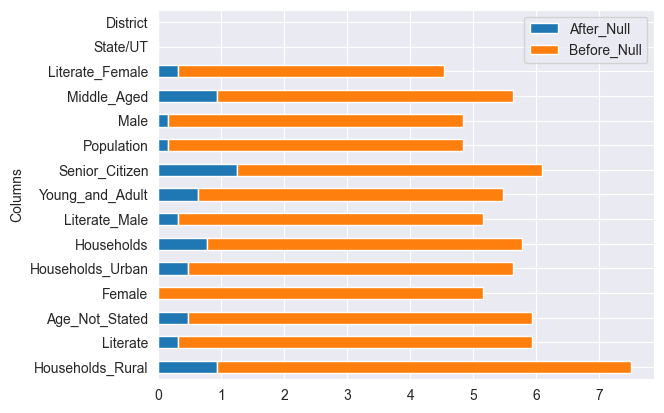

In [180]:
null_percent_compare.plot.barh(x='Columns', y=['After_Null', 'Before_Null'], stacked=True)
plt.show()

#### Problem Statement 6: (Save Data)

In [181]:
# census.df.to_csv(r'E:\Projects\Healthcare Census\Clean_Data\census.csv')

### Housing Data Preprocessing

##### Problem Statement 7: (Process the relevant data)

In [182]:
housing = Preprocessing(housing_df)

In [183]:
housing_cols = ['State Name','District Name', 'Rural/Urban', 'Total Number of households', 'Total Number of Livable', 'Total Number of Dilapidated', 'Latrine_premise']
housing.select_columns(housing_cols)
housing.rename_columns({'State Name': 'State/UT', 'District Name': 'District'})
housing.df.head(6)

,State/UT,District,Rural/Urban,Total Number of households,Total Number of Livable,Total Number of Dilapidated,Latrine_premise
0,JAMMU & KASHMIR,Kupwara,Rural,100,58.1,8.3,48.9
1,JAMMU & KASHMIR,Kupwara,Total,100,57.3,7.9,50.9
2,JAMMU & KASHMIR,Kupwara,Urban,100,49.5,4.8,70.2
3,JAMMU & KASHMIR,Badgam,Rural,100,46.3,3.9,83.3
4,JAMMU & KASHMIR,Badgam,Total,100,44.7,3.8,84.3
5,JAMMU & KASHMIR,Badgam,Urban,100,33.8,2.6,90.4


In [184]:
housing.replace_state('Telangana', telangana_districts)
laddakh_districts = ['Leh(Ladakh)', 'Kargil']
housing.replace_state('Laddakh', laddakh_districts)
# housing.df[housing.df['State/UT']=='Laddakh']
housing.uniform_state_ut('State/UT')
housing.uniform_state_ut('District')
housing.df

,State/UT,District,Rural/Urban,Total Number of households,Total Number of Livable,Total Number of Dilapidated,Latrine_premise
0,Jammu And Kashmir,Kupwara,Rural,100,58.1,8.3,48.9
1,Jammu And Kashmir,Kupwara,Total,100,57.3,7.9,50.9
2,Jammu And Kashmir,Kupwara,Urban,100,49.5,4.8,70.2
3,Jammu And Kashmir,Badgam,Rural,100,46.3,3.9,83.3
4,Jammu And Kashmir,Badgam,Total,100,44.7,3.8,84.3
...,...,...,...,...,...,...,...
1903,Andaman And Nicobar Islands,North And Middle Andaman,Total,100,44.6,2.8,48.3
1904,Andaman And Nicobar Islands,North And Middle Andaman,Urban,100,55.9,6.6,56.1
1905,Andaman And Nicobar Islands,South Andaman,Rural,100,33.5,3.5,64.7
1906,Andaman And Nicobar Islands,South Andaman,Total,100,26.4,2.2,78.3


In [185]:
housing.modify_state('Nct Of Delhi', 'Delhi')
housing.modify_state('Orissa', 'Odisha')
housing.modify_state('Pondicherry', 'Puducherry')
housing.modify_state('Leh(Ladakh)', 'Leh')

In [186]:
test = housing.df.copy()
housing_pivot = test.pivot(index=['State/UT', 'District'], columns=['Rural/Urban'])
housing_pivot.columns = list(map("_".join, housing_pivot.columns))
housing_pivot = housing_pivot.reset_index()
housing_pivot.head(3)

,State/UT,District,Total Number of households_Rural,Total Number of households_Total,Total Number of households_Urban,Total Number of Livable_Rural,Total Number of Livable_Total,Total Number of Livable_Urban,Total Number of Dilapidated_Rural,Total Number of Dilapidated_Total,Total Number of Dilapidated_Urban,Latrine_premise_Rural,Latrine_premise_Total,Latrine_premise_Urban
0,Andaman And Nicobar Islands,Nicobars,100.0,100.0,NaN,23.8,23.8,NaN,1.2,1.2,NaN,80.9,80.9,NaN
1,Andaman And Nicobar Islands,North And Middle Andaman,100.0,100.0,100.0,44.3,44.6,55.9,2.7,2.8,6.6,48.0,48.3,56.1
2,Andaman And Nicobar Islands,South Andaman,100.0,100.0,100.0,33.5,26.4,21.4,3.5,2.2,1.2,64.7,78.3,87.8


In [187]:
census_df.isnull().sum()

District code                     0
State name                        0
District name                     0
Population                       30
Male                             30
                                 ..
Power_Parity_Rs_330000_425000    33
Power_Parity_Rs_425000_545000    30
Power_Parity_Rs_330000_545000    23
Power_Parity_Above_Rs_545000     30
Total_Power_Parity               32
Length: 118, dtype: int64

In [188]:
housing_pivot.isnull().sum()

State/UT                             0
District                             0
Total Number of households_Rural     9
Total Number of households_Total     0
Total Number of households_Urban     3
Total Number of Livable_Rural        9
Total Number of Livable_Total        0
Total Number of Livable_Urban        3
Total Number of Dilapidated_Rural    9
Total Number of Dilapidated_Total    0
Total Number of Dilapidated_Urban    3
Latrine_premise_Rural                9
Latrine_premise_Total                0
Latrine_premise_Urban                3
dtype: int64

In [189]:
census_df = census.df.copy()
merged_df = pd.merge(census_df[['State/UT', 'District', 'Households']], housing_pivot, how='left', on=['State/UT', 'District'])
merged_df.head(3)

,State/UT,District,Households,Total Number of households_Rural,Total Number of households_Total,Total Number of households_Urban,Total Number of Livable_Rural,Total Number of Livable_Total,Total Number of Livable_Urban,Total Number of Dilapidated_Rural,Total Number of Dilapidated_Total,Total Number of Dilapidated_Urban,Latrine_premise_Rural,Latrine_premise_Total,Latrine_premise_Urban
0,Jammu And Kashmir,Kupwara,181664.0,100.0,100.0,100.0,58.1,57.3,49.5,8.3,7.9,4.8,48.9,50.9,70.2
1,Jammu And Kashmir,Badgam,187839.0,100.0,100.0,100.0,46.3,44.7,33.8,3.9,3.8,2.6,83.3,84.3,90.4
2,Laddakh,Leh,54394.0,100.0,100.0,100.0,51.5,52.4,54.6,2.1,1.8,1.1,88.1,90.4,95.8


In [190]:
housing_pivot[housing_pivot['District'] == 'Bharatpur']

,State/UT,District,Total Number of households_Rural,Total Number of households_Total,Total Number of households_Urban,Total Number of Livable_Rural,Total Number of Livable_Total,Total Number of Livable_Urban,Total Number of Dilapidated_Rural,Total Number of Dilapidated_Total,Total Number of Dilapidated_Urban,Latrine_premise_Rural,Latrine_premise_Total,Latrine_premise_Urban
459,Rajasthan,Bharatpur,100.0,100.0,100.0,54.5,52.0,42.0,4.7,4.2,2.4,7.8,20.3,69.5


In [191]:
merged_copy = merged_df.copy()
merged_copy.drop(columns=['Total Number of households_Rural', 'Total Number of households_Total', 'Total Number of households_Urban', 'Total Number of Livable_Total', 'Total Number of Dilapidated_Total'], inplace=True)

for col in merged_copy.columns[3:]:
    merged_copy[col] = merged_copy[col] * merged_copy['Households'] / 100

In [192]:
merged_copy

,State/UT,District,Households,Total Number of Livable_Rural,Total Number of Livable_Urban,Total Number of Dilapidated_Rural,Total Number of Dilapidated_Urban,Latrine_premise_Rural,Latrine_premise_Total,Latrine_premise_Urban
0,Jammu And Kashmir,Kupwara,181664.0,105546.784,89923.680,15078.112,8719.872,88833.696,92466.976,127528.128
1,Jammu And Kashmir,Badgam,187839.0,86969.457,63489.582,7325.721,4883.814,156469.887,158348.277,169806.456
2,Laddakh,Leh,54394.0,28012.910,29699.124,1142.274,598.334,47921.114,49172.176,52109.452
3,Laddakh,Kargil,48144.0,35289.552,33123.072,1685.040,577.728,46603.392,46651.536,46940.400
4,Jammu And Kashmir,Punch,147408.0,87707.760,40242.384,3537.792,1179.264,20194.896,27565.296,110998.224
...,...,...,...,...,...,...,...,...,...,...
635,Puducherry,Mahe,12110.0,NaN,1913.380,NaN,133.210,NaN,11843.580,11843.580
636,Puducherry,Karaikal,69333.0,25514.544,14559.930,1455.993,831.996,33002.508,42015.798,51583.752
637,Andaman And Nicobar Islands,Nicobars,15958.0,3798.004,NaN,191.496,NaN,12910.022,12910.022,NaN
638,Andaman And Nicobar Islands,North And Middle Andaman,40185.0,17801.955,22463.415,1084.995,2652.210,19288.800,19409.355,22543.785


In [193]:
housing.df = merged_copy
cols = {'Total Number of Livable_Rural': 'Households_Rural_Livable', 'Total Number of Livable_Urban': 'Households_Urban_Livable', 'Total Number of Dilapidated_Rural': 'Households_Rural_Dilapidated', 'Total Number of Dilapidated_Urban': 'Households_Urban_Dilapidated', 'Latrine_premise_Rural': 'Households_Rural_Toilet_Premise', 'Latrine_premise_Urban': 'Households_Urban_Toilet_Premise'}
housing.rename_columns(cols)
housing.df.head(2)

,State/UT,District,Households,Households_Rural_Livable,Households_Urban_Livable,Households_Rural_Dilapidated,Households_Urban_Dilapidated,Households_Rural_Toilet_Premise,Latrine_premise_Total,Households_Urban_Toilet_Premise
0,Jammu And Kashmir,Kupwara,181664.0,105546.784,89923.680,15078.112,8719.872,88833.696,92466.976,127528.128
1,Jammu And Kashmir,Badgam,187839.0,86969.457,63489.582,7325.721,4883.814,156469.887,158348.277,169806.456


In [194]:
housing.df.isnull().sum()

State/UT                            0
District                            0
Households                          5
Households_Rural_Livable           14
Households_Urban_Livable            8
Households_Rural_Dilapidated       14
Households_Urban_Dilapidated        8
Households_Rural_Toilet_Premise    14
Latrine_premise_Total               5
Households_Urban_Toilet_Premise     8
dtype: int64

In [195]:
housing.df[housing.df['Households'].isnull()]

,State/UT,District,Households,Households_Rural_Livable,Households_Urban_Livable,Households_Rural_Dilapidated,Households_Urban_Dilapidated,Households_Rural_Toilet_Premise,Latrine_premise_Total,Households_Urban_Toilet_Premise
104,Rajasthan,Bharatpur,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,Arunachal Pradesh,West Kameng,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400,Chhattisgarh,Surguja,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,Chhattisgarh,Jashpur,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
553,Andhra Pradesh,Chittoor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**District Data Missing in Census Dataframe are:**
- Bharatpur
- West Kameng
- Surguja
- Jashpur
- Chittoor

In [196]:
# housing.df.to_csv(r'E:\Projects\Healthcare Census\Clean_Data\housing.csv')


#### Problem Statement 8: (Visualise the housing data)

##### Visualize A: Number of households for 100 people

In [197]:
perhundred = census.df[['State/UT', 'Population', 'Households']].copy()
perhundred_state = perhundred.groupby('State/UT').sum().reset_index()
perhundred_state['Hundred_per_Household'] = (perhundred_state['Households'] * 100 )/ perhundred_state['Population']
perhundred_state

,State/UT,Population,Households,Hundred_per_Household
0,Andaman And Nicobar Islands,380581.0,141675.0,37.225978
1,Andhra Pradesh,49386799.0,14212527.0,28.777988
2,Arunachal Pradesh,1383727.0,351765.0,25.421561
3,Assam,31205576.0,9074503.0,29.079748
4,Bihar,104099452.0,23414674.0,22.492601
5,Chandigarh,1055450.0,298367.0,28.269174
6,Chhattisgarh,25545198.0,5982534.0,23.419407
7,Dadra And Nagar Haveli,343709.0,108783.0,31.649739
8,Daman And Diu,243247.0,89929.0,36.970240
9,Delhi,16787941.0,4605555.0,27.433710


In [198]:
perhundred_state = perhundred_state.sort_values(by=['Hundred_per_Household'])
perhundred_state_min = perhundred_state[:5]
perhundred_state_min[['State/UT', 'Hundred_per_Household']]

,State/UT,Hundred_per_Household
22,Manipur,21.358824
4,Bihar,22.492601
34,Uttar Pradesh,22.607434
6,Chhattisgarh,23.419407
15,Jharkhand,23.632840


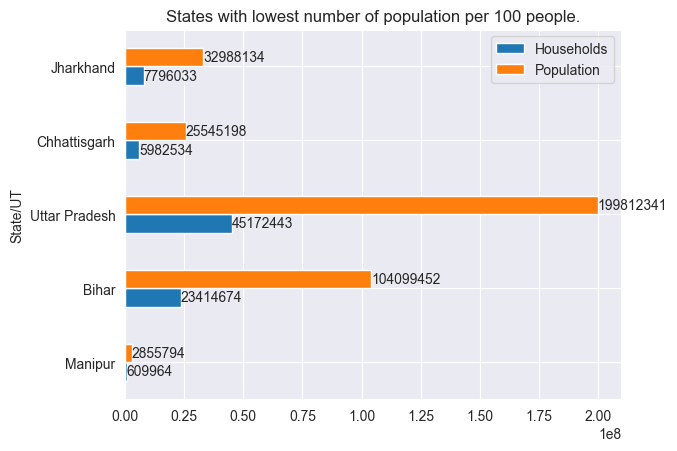

In [199]:
ax = perhundred_state_min.plot.barh( x='State/UT', y=['Households','Population' ])
plt.title('States with lowest number of population per 100 people.')
for bars in ax.containers:
    ax.bar_label(bars, fmt='%d')

In [200]:
perhundred_state = perhundred_state.sort_values(by=['Hundred_per_Household'])
perhundred_state_max = perhundred_state[-5:]
perhundred_state_max[['State/UT', 'Hundred_per_Household']]

,State/UT,Hundred_per_Household
8,Daman And Diu,36.970240
0,Andaman And Nicobar Islands,37.225978
18,Laddakh,37.383198
10,Goa,39.531314
13,Himachal Pradesh,42.736097


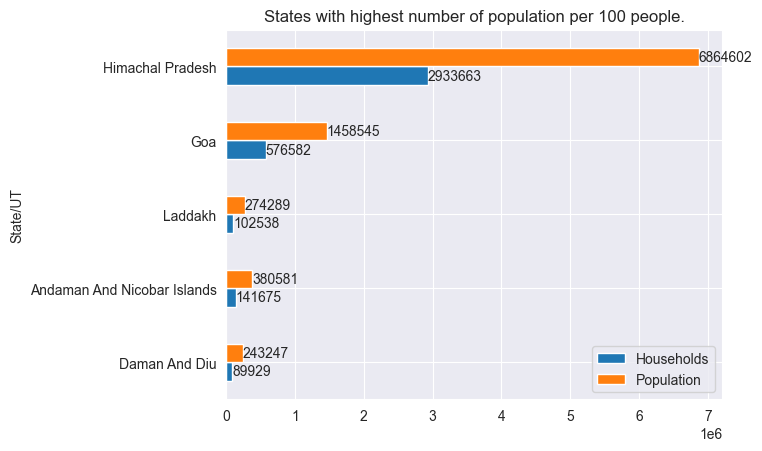

In [201]:
ax = perhundred_state_max.plot.barh( x='State/UT', y=['Households','Population' ])
plt.title('States with highest number of population per 100 people.')
for bars in ax.containers:
    ax.bar_label(bars, fmt='%d')

In [202]:
map_df.loc[36, 'st_nm'] = 'Laddakh'

In [203]:
merged = map_df.set_index('st_nm').join(perhundred_state.set_index('State/UT'))
merged


,id,geometry,Population,Households,Hundred_per_Household
st_nm,,,,,
Andaman and Nicobar Islands,NaN,"MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0...",NaN,NaN,NaN
Arunachal Pradesh,NaN,"POLYGON ((95.23643 26.68105, 95.19594 27.03612...",1383727.0,351765.0,25.421561
Assam,NaN,"POLYGON ((95.19594 27.03612, 95.08795 26.94578...",31205576.0,9074503.0,29.079748
Bihar,NaN,"POLYGON ((88.11357 26.54028, 88.28006 26.37640...",104099452.0,23414674.0,22.492601
Chandigarh,NaN,"POLYGON ((76.84208 30.76124, 76.83758 30.72552...",1055450.0,298367.0,28.269174
Chhattisgarh,NaN,"POLYGON ((83.94694 23.62196, 83.95594 23.62406...",25545198.0,5982534.0,23.419407
Dadra and Nagar Haveli,NaN,"POLYGON ((73.20640 20.12165, 73.20865 20.10695...",NaN,NaN,NaN
Daman and Diu,NaN,"POLYGON ((72.80144 20.37378, 72.84418 20.47463...",NaN,NaN,NaN
Goa,NaN,"POLYGON ((74.11982 15.65278, 74.24806 15.65698...",1458545.0,576582.0,39.531314


<Axes: title={'center': 'Number of households for 100 people'}>

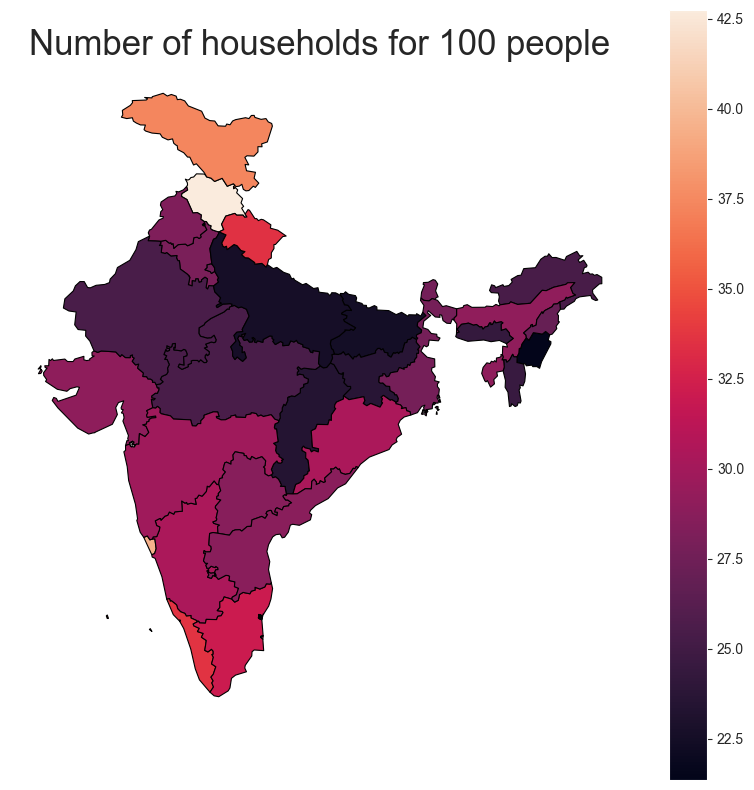

In [204]:
# create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Number of households for 100 people', fontdict={'fontsize': '25', 'fontweight' : '10'})

# plot the figure
merged.plot(column='Hundred_per_Household', linewidth=0.8, ax=ax, edgecolor='0', legend=True,markersize=[39.739192, -104.990337])

In [205]:
import plotly.express as px

fig = px.choropleth(
    perhundred_state,
    geojson=r"india_states.geojson",
    featureidkey='properties.ST_NM',
    locations='State/UT',
    
    color='Hundred_per_Household',
    color_continuous_scale='ice'
)

fig.update_geos(fitbounds="locations", visible=False)

fig.show()

##### Visualize B: Percentage of households that have toilet(s) in premise to the total number of households.

In [206]:
latrine_df = housing.df.copy()
latrine_total = latrine_df.groupby('State/UT').sum().reset_index()
latrine_total['Percent_Latrine'] = (latrine_total['Latrine_premise_Total'] * 100 )/ latrine_total['Households']
latrine_total.head(2)

C:\Users\farya\AppData\Local\Temp\ipykernel_18884\3854565685.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,State/UT,Households,Households_Rural_Livable,Households_Urban_Livable,Households_Rural_Dilapidated,Households_Urban_Dilapidated,Households_Rural_Toilet_Premise,Latrine_premise_Total,Households_Urban_Toilet_Premise,Percent_Latrine
0,Andaman And Nicobar Islands,141675.0,50253.179,40767.263,4270.111,3678.594,87538.026,99290.933,9.764088e+04,70.083595
1,Andhra Pradesh,14212527.0,4089557.768,2863939.283,536551.915,235895.043,4924582.633,6844200.811,1.153264e+07,48.156115


In [207]:
latrine_total

,State/UT,Households,Households_Rural_Livable,Households_Urban_Livable,Households_Rural_Dilapidated,Households_Urban_Dilapidated,Households_Rural_Toilet_Premise,Latrine_premise_Total,Households_Urban_Toilet_Premise,Percent_Latrine
0,Andaman And Nicobar Islands,141675.0,5.025318e+04,4.076726e+04,4.270111e+03,3.678594e+03,8.753803e+04,9.929093e+04,9.764088e+04,70.083595
1,Andhra Pradesh,14212527.0,4.089558e+06,2.863939e+06,5.365519e+05,2.358950e+05,4.924583e+06,6.844201e+06,1.153264e+07,48.156115
2,Arunachal Pradesh,351765.0,1.627139e+05,1.413086e+05,1.184779e+04,8.834059e+03,1.912625e+05,2.225652e+05,3.118770e+05,63.270980
3,Assam,9074503.0,5.443589e+06,3.454015e+06,1.044843e+06,5.891659e+05,5.432790e+06,5.864566e+06,8.379795e+06,64.626854
4,Bihar,23414674.0,1.371973e+07,9.831444e+06,1.742693e+06,1.669215e+06,4.177150e+06,5.383555e+06,1.490827e+07,22.992227
5,Chandigarh,298367.0,1.399341e+05,7.936562e+04,8.354276e+03,1.044284e+04,2.625630e+05,2.613695e+05,2.613695e+05,87.600000
6,Chhattisgarh,5982534.0,3.304423e+06,2.091889e+06,2.813451e+05,1.744867e+05,8.247031e+05,1.499825e+06,3.496533e+06,25.070054
7,Dadra And Nagar Haveli,108783.0,4.949626e+04,2.262686e+04,8.702640e+02,2.175660e+02,2.882749e+04,5.950430e+04,8.844058e+04,54.700000
8,Daman And Diu,89929.0,2.115881e+04,2.838726e+04,6.962610e+02,4.641740e+02,4.889032e+04,6.965290e+04,7.577752e+04,77.453209
9,Delhi,4605555.0,1.633826e+06,1.445092e+06,1.357472e+05,1.288260e+05,3.711286e+06,4.117498e+06,4.130815e+06,89.402873


In [208]:
latrine_test = latrine_total[['State/UT', 'Latrine_premise_Total', 'Households', 'Percent_Latrine']].sort_values(by=['Percent_Latrine'])
latrine_test_min = latrine_test[:3]
latrine_test_min

,State/UT,Latrine_premise_Total,Households,Percent_Latrine
26,Odisha,2833772.705,12759133.0,22.209759
15,Jharkhand,1751368.475,7796033.0,22.464867
4,Bihar,5383555.018,23414674.0,22.992227


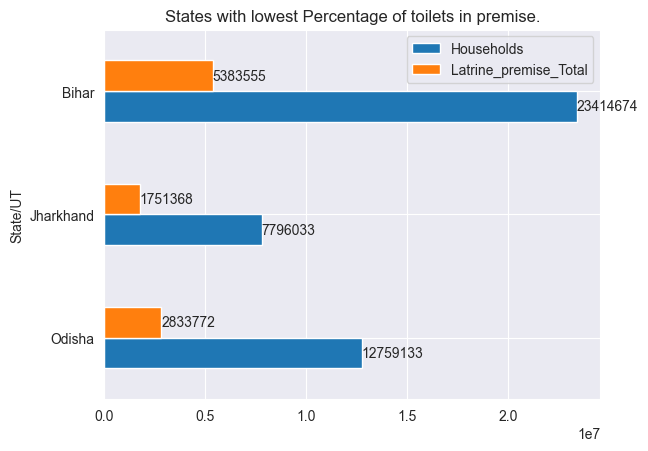

In [209]:
ax = latrine_test_min.plot.barh( x='State/UT', y=['Households','Latrine_premise_Total' ])

plt.title('States with lowest Percentage of toilets in premise.')
for bars in ax.containers:
    ax.bar_label(bars, fmt='%d')

In [210]:
latrine_test = latrine_total[['State/UT', 'Latrine_premise_Total', 'Households', 'Percent_Latrine']].sort_values(by=['Percent_Latrine'], ascending=False)
latrine_test_max = latrine_test[:3]
latrine_test_max

,State/UT,Latrine_premise_Total,Households,Percent_Latrine
19,Lakshadweep,2.077468e+04,21242.0,97.800000
17,Kerala,1.068204e+07,11217853.0,95.223529
18,Laddakh,9.582371e+04,102538.0,93.451903


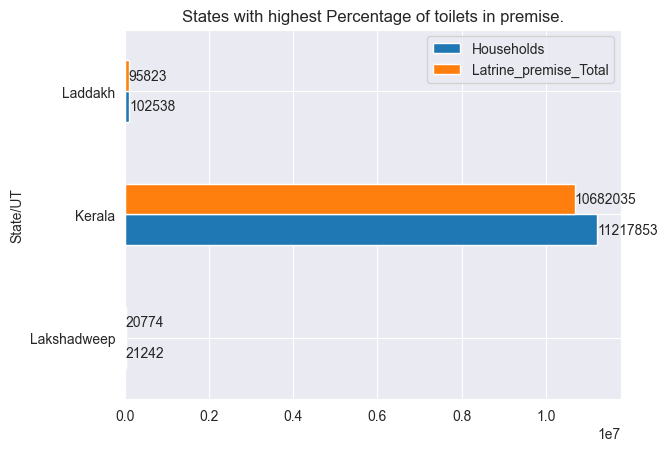

In [211]:
ax = latrine_test_max.plot.barh( x='State/UT', y=['Households','Latrine_premise_Total' ])
plt.title('States with highest Percentage of toilets in premise.')
for bars in ax.containers:
    ax.bar_label(bars, fmt='%d')

In [212]:
merged_latrine = map_df.set_index('st_nm').join(latrine_total.set_index('State/UT'))
merged_latrine.head(2)


,id,geometry,Households,Households_Rural_Livable,Households_Urban_Livable,Households_Rural_Dilapidated,Households_Urban_Dilapidated,Households_Rural_Toilet_Premise,Latrine_premise_Total,Households_Urban_Toilet_Premise,Percent_Latrine
st_nm,,,,,,,,,,,
Andaman and Nicobar Islands,NaN,"MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arunachal Pradesh,NaN,"POLYGON ((95.23643 26.68105, 95.19594 27.03612...",351765.0,162713.89,141308.631,11847.789,8834.059,191262.478,222565.162,311877.002,63.27098


<Axes: title={'center': 'Percentage of household that have toilets in premise.'}>

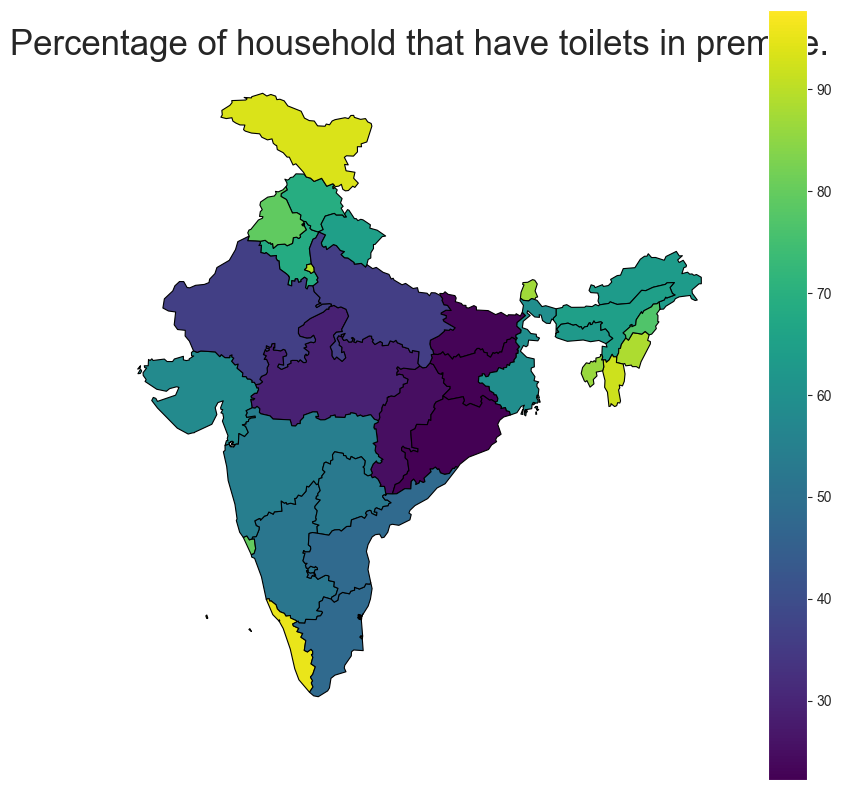

In [213]:
# create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Percentage of household that have toilets in premise.', fontdict={'fontsize': '25', 'fontweight' : '10'})

# plot the figure
merged_latrine.plot(column='Percent_Latrine', linewidth=0.8,cmap='viridis', ax=ax, edgecolor='0', legend=True,markersize=[39.739192, -104.990337])

In [214]:
import plotly.express as px

fig = px.choropleth(
    latrine_total,
    geojson=r"india_states.geojson",
    featureidkey='properties.ST_NM',
    locations='State/UT',
    
    color='Percent_Latrine',
    color_continuous_scale='viridis'
)

fig.update_geos(fitbounds="locations", visible=False)

fig.show()

### Hospital  Data Preprocessing

#### Problem Statement 10: (Fix the header)

In [215]:
hospital = Preprocessing(hospitals_df)
hospital.df.head(2)

,Unnamed: 0,PHC,CHC,SDH,DH,Hospitals,HospitalBeds
0,Andaman & Nicobar Islands,27,4,NaN,3,34,1246
1,Andhra Pradesh,1417,198,31,20,1666,60799


In [216]:
hospital.dfInfo()

(37, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    37 non-null     object
 1   PHC           37 non-null     object
 2   CHC           37 non-null     object
 3   SDH           30 non-null     object
 4   DH            37 non-null     object
 5   Hospitals     37 non-null     object
 6   HospitalBeds  37 non-null     object
dtypes: object(7)
memory usage: 2.1+ KB
None


In [217]:
hosp_cols = {'Unnamed: 0': 'State/UT', 'PHC': 'Primary_Health_Centers', 'CHC': 'Community_Health_Centers', 'SDH':'Sub_District_Hosps', 'DH':'District_Hosps'}
hospital.rename_columns(hosp_cols)
hospital.df.tail(2)

,State/UT,Primary_Health_Centers,Community_Health_Centers,Sub_District_Hosps,District_Hosps,Hospitals,HospitalBeds
35,West Bengal,1374,406,70,55,1905,51163
36,All India,"29,899","5,568","1,255","1,003","37,725","7,39,024"


In [218]:
hospital.df['HospitalBeds'] = hospital.df['HospitalBeds'].str.replace(',','').astype('float64')
hospital.df.dtypes

State/UT                     object
Primary_Health_Centers       object
Community_Health_Centers     object
Sub_District_Hosps           object
District_Hosps               object
Hospitals                    object
HospitalBeds                float64
dtype: object

#### Problem Statement 11: (Create a function to alter the data to create uniformity)

In [219]:
# add uniformity to the two columns
hospital.uniform_state_ut('State/UT')
hospital.df['State/UT'].unique()

# hospital.modify_state('Nct Of Delhi', 'Delhi')
# hospital.modify_state('Orissa', 'Odisha')
# hospital.modify_state('Pondicherry', 'Puducherry')


array(['Andaman And Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh',
       'Chhattisgarh', 'Dadra And Nagar Haveli', 'Daman And Diu', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu And Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal',
       'All India'], dtype=object)

In [220]:
# hospital.df.to_csv(r'E:\Projects\Healthcare Census\Clean_Data\all_hospitals.csv')

#### Problem Statement 12: (Analyze Healthcare facility disparity)

In [221]:
hospital.df.tail(4)

,State/UT,Primary_Health_Centers,Community_Health_Centers,Sub_District_Hosps,District_Hosps,Hospitals,HospitalBeds
33,Uttar Pradesh,3277,671,NaN,174,4122,58310.0
34,Uttarakhand,275,69,19,20,383,6660.0
35,West Bengal,1374,406,70,55,1905,51163.0
36,All India,"29,899","5,568","1,255","1,003","37,725",739024.0


In [222]:
census_df = census.df.copy().groupby('State/UT')['Population'].sum().reset_index()
census_df.loc[37, 'State/UT'] = 'All India'
census_df.loc[37, 'Population'] = census_df['Population'].sum(axis=0)
census_df.tail(2)


,State/UT,Population
36,West Bengal,9.127612e+07
37,All India,1.209008e+09


In [223]:

state_hospitalbeds = hospital.df.copy()
merged_hospitalbeds = pd.merge(census_df[['State/UT', 'Population']], state_hospitalbeds[['State/UT', 'HospitalBeds']], how='outer', on='State/UT')
merged_hospitalbeds['HBeds_tenthousand'] = (merged_hospitalbeds['HospitalBeds'] * 10000) / merged_hospitalbeds['Population']
merged_hospitalbeds

,State/UT,Population,HospitalBeds,HBeds_tenthousand
0,Andaman And Nicobar Islands,3.805810e+05,1246.0,32.739417
1,Andhra Pradesh,4.938680e+07,60799.0,12.310780
2,Arunachal Pradesh,1.383727e+06,2320.0,16.766313
3,Assam,3.120558e+07,19115.0,6.125508
4,Bihar,1.040995e+08,17796.0,1.709519
5,Chandigarh,1.055450e+06,3756.0,35.586717
6,Chhattisgarh,2.554520e+07,14354.0,5.619060
7,Dadra And Nagar Haveli,3.437090e+05,568.0,16.525607
8,Daman And Diu,2.432470e+05,298.0,12.250922
9,Delhi,1.678794e+07,20572.0,12.254034


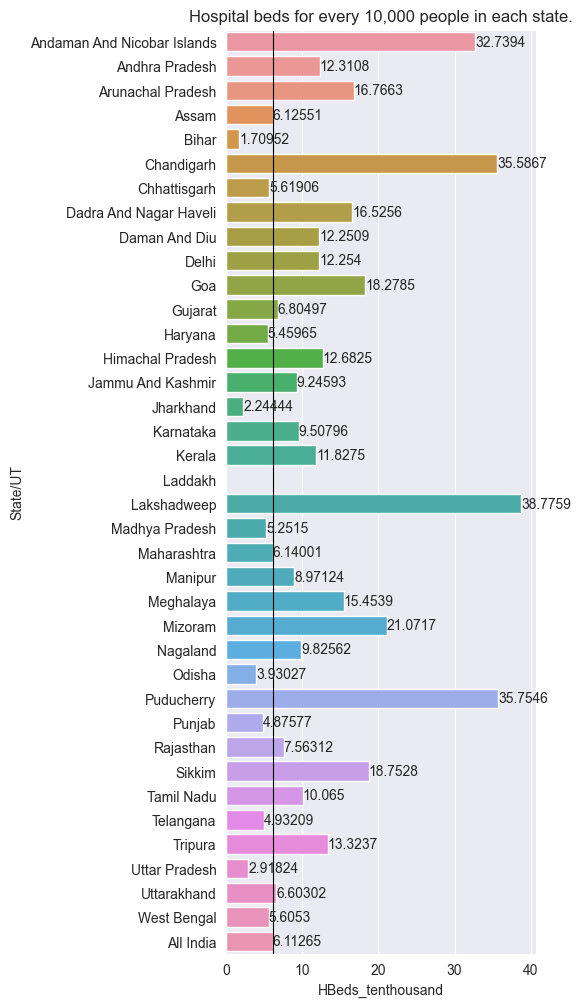

In [224]:
plt.figure(figsize=(4,12))
plt.vlines(x = 6.112648, ymin = -1, ymax = 38, color = 'black', linewidth=0.8)
ax = sns.barplot(data=merged_hospitalbeds, y='State/UT', x='HBeds_tenthousand')
plt.title('Hospital beds for every 10,000 people in each state.')
ax.bar_label(ax.containers[0])
plt.show()


In [225]:
merged_hospitalbeds[merged_hospitalbeds['HBeds_tenthousand'] < 6.112648].sort_values(by=['HBeds_tenthousand'])

,State/UT,Population,HospitalBeds,HBeds_tenthousand
4,Bihar,1.040995e+08,17796.0,1.709519
15,Jharkhand,3.298813e+07,7404.0,2.244443
34,Uttar Pradesh,1.998123e+08,58310.0,2.918238
26,Odisha,4.197422e+07,16497.0,3.930270
28,Punjab,2.774334e+07,13527.0,4.875765
32,Telangana,3.519398e+07,17358.0,4.932094
20,Madhya Pradesh,7.262681e+07,38140.0,5.251504
12,Haryana,2.535146e+07,13841.0,5.459646
36,West Bengal,9.127612e+07,51163.0,5.605300
6,Chhattisgarh,2.554520e+07,14354.0,5.619060


In [226]:
merged_hospitalbeds_sorted = merged_hospitalbeds.sort_values(by=['HBeds_tenthousand'])[:3]
merged_hospitalbeds_sorted


,State/UT,Population,HospitalBeds,HBeds_tenthousand
4,Bihar,104099452.0,17796.0,1.709519
15,Jharkhand,32988134.0,7404.0,2.244443
34,Uttar Pradesh,199812341.0,58310.0,2.918238


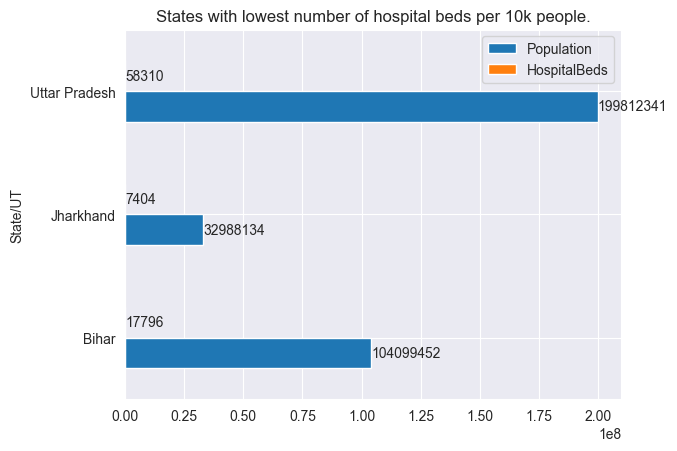

In [227]:
# merged_hospitalbeds_sorted.plot.barh( x='State/UT', y=['HospitalBeds','Population', ])
ax = merged_hospitalbeds_sorted.plot.barh( x='State/UT', y=['Population', 'HospitalBeds' ])
plt.title('States with lowest number of hospital beds per 10k people.')
for bars in ax.containers:
    ax.bar_label(bars, fmt='%d')

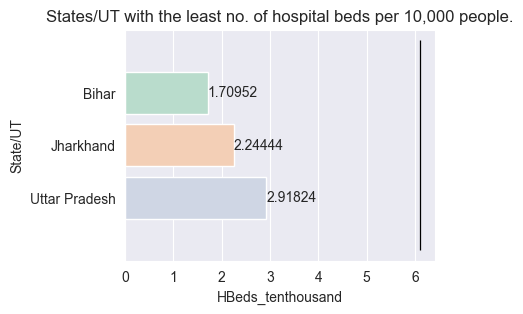

In [228]:
plt.figure(figsize=(4,3))
ax = sns.barplot(data=merged_hospitalbeds_sorted, y='State/UT', x='HBeds_tenthousand', palette='Pastel2')
plt.title('States/UT with the least no. of hospital beds per 10,000 people.')
plt.vlines(x = 6.112648, ymin = -1, ymax = 3, color = 'black', linewidth=0.9)
ax.bar_label(ax.containers[0])
plt.show()


### Government Hospitals Data Preprocessing

#### Problem Statement 13: (Multi-line header)

In [229]:
government = Preprocessing(government_df)
government.df.head(2)

,States/UTs,Rural hospitals,Unnamed: 2,Urban hospitals,Unnamed: 4,As on
0,NaN,No.,Beds,No.,Beds,NaN
1,Andhra Pradesh,193,6480,65,16658,01.01.2017


In [230]:
govern_cols = {'States/UTs': 'State/UT', 'Rural hospitals': 'Rural_Government_Hospitals', 'Unnamed: 2': 'Rural_Government_Beds', 'Urban hospitals': 'Urban_Government_Hospitals', 'Unnamed: 4': 'Urban_Government_Beds', 'As on': 'Last_Updated'}
government.rename_columns(govern_cols)

In [231]:
government.df = government.df.iloc[1:].reset_index(drop=True)
government.df.head(3)


,State/UT,Rural_Government_Hospitals,Rural_Government_Beds,Urban_Government_Hospitals,Urban_Government_Beds,Last_Updated
0,Andhra Pradesh,193,6480,65,16658,01.01.2017
1,Arunachal Pradesh*,208,2136,10,268,31.12.2017
2,Assam,1176,10944,50,6198,31.12.2017


#### Problem Statement 14: (Data update and code reuse

In [232]:
government.uniform_state_ut('State/UT')
government.df.head(5)

,State/UT,Rural_Government_Hospitals,Rural_Government_Beds,Urban_Government_Hospitals,Urban_Government_Beds,Last_Updated
0,Andhra Pradesh,193,6480,65,16658,01.01.2017
1,Arunachal Pradesh,208,2136,10,268,31.12.2017
2,Assam,1176,10944,50,6198,31.12.2017
3,Bihar,930,6083,103,5936,31.12.2016
4,Chhattisgarh,169,5070,45,4342,01.01.2016


In [233]:
government.df['State/UT'].unique()

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chhattisgarh', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu And Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram',
       'Nagaland', 'Odisha', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh',
       'Uttarakhand', 'West Bengal', 'Andaman And Nicobar Islands',
       'Chandigarh', 'Dadra And Nagar Haveli', 'Daman And Diu', 'Delhi',
       'Lakshadweep', 'Puducherry', 'India'], dtype=object)

In [234]:
government.dfInfo()

(37, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   State/UT                    37 non-null     object
 1   Rural_Government_Hospitals  37 non-null     object
 2   Rural_Government_Beds       37 non-null     object
 3   Urban_Government_Hospitals  37 non-null     object
 4   Urban_Government_Beds       37 non-null     object
 5   Last_Updated                36 non-null     object
dtypes: object(6)
memory usage: 1.9+ KB
None


In [235]:
government.df.isnull().sum()


State/UT                      0
Rural_Government_Hospitals    0
Rural_Government_Beds         0
Urban_Government_Hospitals    0
Urban_Government_Beds         0
Last_Updated                  1
dtype: int64

In [236]:
government.df['Last_Updated']=pd.to_datetime(government.df['Last_Updated'],format='%d.%m.%Y')
government.dfInfo()


(37, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   State/UT                    37 non-null     object        
 1   Rural_Government_Hospitals  37 non-null     object        
 2   Rural_Government_Beds       37 non-null     object        
 3   Urban_Government_Hospitals  37 non-null     object        
 4   Urban_Government_Beds       37 non-null     object        
 5   Last_Updated                36 non-null     datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 1.9+ KB
None


In [237]:
government.df.head(3)

,State/UT,Rural_Government_Hospitals,Rural_Government_Beds,Urban_Government_Hospitals,Urban_Government_Beds,Last_Updated
0,Andhra Pradesh,193,6480,65,16658,2017-01-01
1,Arunachal Pradesh,208,2136,10,268,2017-12-31
2,Assam,1176,10944,50,6198,2017-12-31


In [238]:
# government.df.to_csv(r'E:\Projects\Healthcare Census\Clean_Data\government_hospital.csv')

#### Problem Statement 15: (Government healthcare facility disparity)

In [239]:
gov = government.df.copy()
for col in government.df.columns[2:-1]:
    government.df[col] = government.df[col].astype('float32')
    
census_df = census.df.copy().groupby('State/UT')['Population'].sum().reset_index()
census_df.loc[37, 'State/UT'] = 'All India'
census_df.loc[37, 'Population'] = census_df['Population'].sum(axis=0)
census_df.tail(2)
hosp_gov = pd.merge(census_df[['State/UT', 'Population']], gov, how='left', on=['State/UT'])
hosp_gov.head(3)

,State/UT,Population,Rural_Government_Hospitals,Rural_Government_Beds,Urban_Government_Hospitals,Urban_Government_Beds,Last_Updated
0,Andaman And Nicobar Islands,380581.0,27,575,3,500,2016-12-31
1,Andhra Pradesh,49386799.0,193,6480,65,16658,2017-01-01
2,Arunachal Pradesh,1383727.0,208,2136,10,268,2017-12-31


In [240]:
hosp_gov['Rural_Government_Hospitals']= hosp_gov['Rural_Government_Hospitals'].astype('float32')

In [243]:
hosp_gov['Total_Gov_Beds'] = hosp_gov['Rural_Government_Beds'] + hosp_gov['Urban_Government_Beds']
# hosp_gov['Total_Hosps'] = hosp_gov['Rural_Government_Hospitals'] + hosp_gov['Urban_Government_Hospitals']

hosp_gov_new = hosp_gov[['State/UT', 'Population', 'Total_Gov_Beds']]
hosp_gov_new['Total_Gov_Beds']= hosp_gov_new['Total_Gov_Beds'].astype('float32')
hosp_gov_new['GovBeds_perPop'] = (hosp_gov_new['Total_Gov_Beds'] * 10000 )/ hosp_gov_new['Population']
hosp_gov_new

C:\Users\farya\AppData\Local\Temp\ipykernel_18884\2130149627.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\farya\AppData\Local\Temp\ipykernel_18884\2130149627.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,State/UT,Population,Total_Gov_Beds,GovBeds_perPop
0,Andaman And Nicobar Islands,3.805810e+05,5.755000e+05,15121.616182
1,Andhra Pradesh,4.938680e+07,6.480166e+08,131212.526041
2,Arunachal Pradesh,1.383727e+06,2.136268e+06,15438.507602
3,Assam,3.120558e+07,1.094462e+08,35072.642576
4,Bihar,1.040995e+08,6.083594e+07,5844.020680
5,Chandigarh,1.055450e+06,7.780000e+02,7.371263
6,Chhattisgarh,2.554520e+07,5.070434e+07,19848.875189
7,Dadra And Nagar Haveli,3.437090e+05,2.733160e+05,7951.959175
8,Daman And Diu,2.432470e+05,2.400000e+03,98.665143
9,Delhi,1.678794e+07,2.438300e+04,14.524116


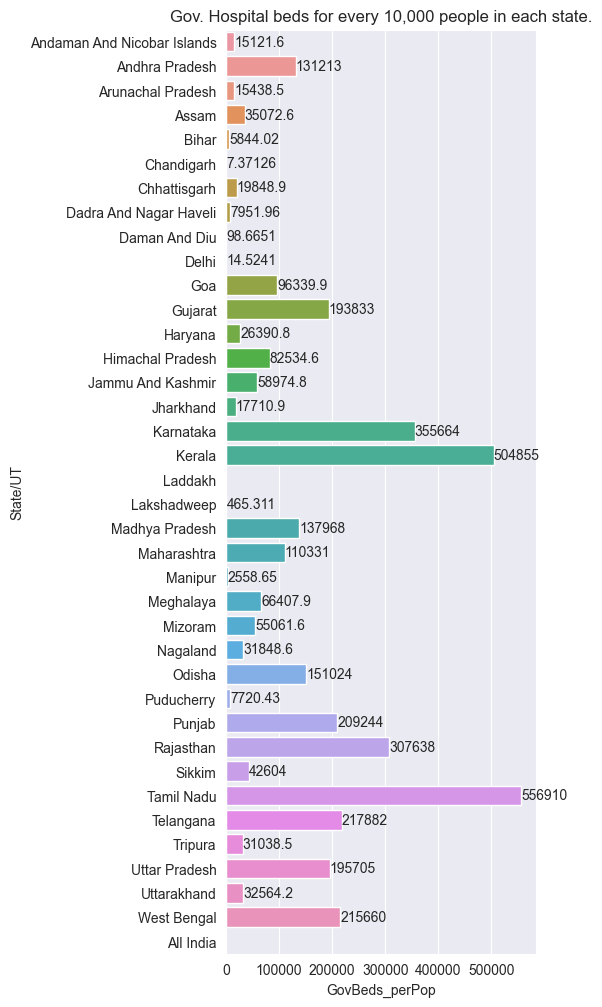

In [246]:
plt.figure(figsize=(4,12))
# plt.vlines(x = 6.112648, ymin = -1, ymax = 38, color = 'black', linewidth=0.8)
ax = sns.barplot(data=hosp_gov_new, y='State/UT', x='GovBeds_perPop')
plt.title('Gov. Hospital beds for every 10,000 people in each state.')
ax.bar_label(ax.containers[0])
plt.show()


In [247]:
gov_hospitalbeds_sorted = hosp_gov_new.sort_values(by=['GovBeds_perPop'])[:3]
gov_hospitalbeds_sorted


,State/UT,Population,Total_Gov_Beds,GovBeds_perPop
5,Chandigarh,1055450.0,778.0,7.371263
9,Delhi,16787941.0,24383.0,14.524116
8,Daman And Diu,243247.0,2400.0,98.665143


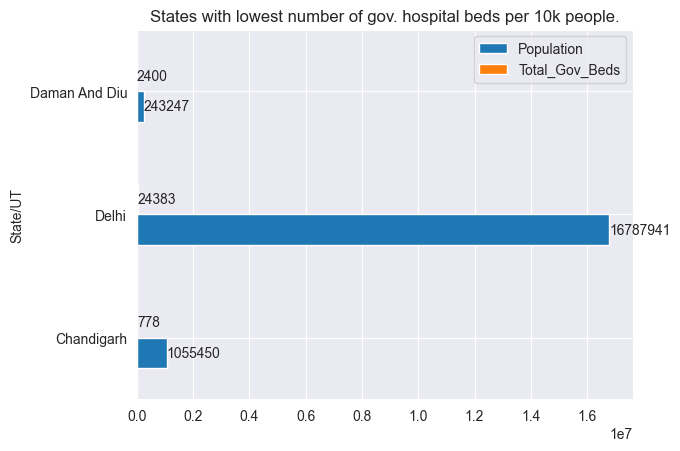

In [248]:
ax = gov_hospitalbeds_sorted.plot.barh( x='State/UT', y=['Population','Total_Gov_Beds' ])
plt.title('States with lowest number of gov. hospital beds per 10k people.')
for bars in ax.containers:
    ax.bar_label(bars, fmt='%d')

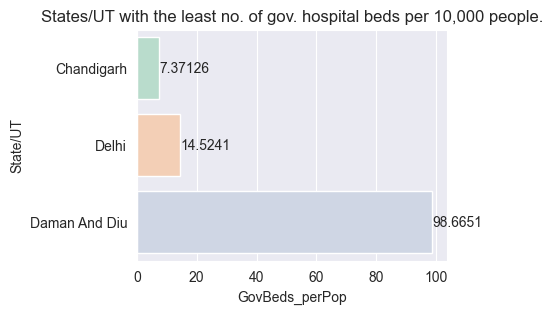

In [249]:
plt.figure(figsize=(4,3))
ax = sns.barplot(data=gov_hospitalbeds_sorted, y='State/UT', x='GovBeds_perPop', palette='Pastel2')
plt.title('States/UT with the least no. of gov. hospital beds per 10,000 people.')
# plt.vlines(x = 6.112648, ymin = -1, ymax = 3, color = 'black', linewidth=0.9)
ax.bar_label(ax.containers[0])
plt.show()


#### Problem Statement 16: (Gap in number of beds)

In [250]:
hosp_df = hospital.df.copy()
hosp_df.head()

,State/UT,Primary_Health_Centers,Community_Health_Centers,Sub_District_Hosps,District_Hosps,Hospitals,HospitalBeds
0,Andaman And Nicobar Islands,27,4,NaN,3,34,1246.0
1,Andhra Pradesh,1417,198,31,20,1666,60799.0
2,Arunachal Pradesh,122,62,NaN,15,199,2320.0
3,Assam,1007,166,14,33,1220,19115.0
4,Bihar,2007,63,33,43,2146,17796.0


In [273]:
for col in gov.columns[1:-2]:
    gov[col] = gov[col].astype('float64')

# gov['Total_Hosps']= gov['Total_Hosps'].astype('float32')

gov.head(2)

,State/UT,Rural_Government_Hospitals,Rural_Government_Beds,Urban_Government_Hospitals,Urban_Government_Beds,Last_Updated,Total_Hosps
0,Andhra Pradesh,193.0,6480.0,65.0,16658.0,2017-01-01,258.0
1,Arunachal Pradesh,208.0,2136.0,10.0,268.0,2017-12-31,218.0


In [274]:
gov['Total_Hosps'] = gov['Rural_Government_Hospitals'] + gov['Urban_Government_Hospitals']
# gov


In [275]:
census_df = census.df.copy().groupby('State/UT')['Population'].sum().reset_index()
census_df.loc[37, 'State/UT'] = 'All India'
census_df.loc[37, 'Population'] = census_df['Population'].sum(axis=0)
census_df.tail(2)
hosp_gov_who = pd.merge(census_df[['State/UT', 'Population']], gov[['Rural_Government_Beds', 'Urban_Government_Beds','State/UT', 'Total_Hosps']], how='left', on=['State/UT'])
hosp_gov_who = pd.merge(hosp_gov_who, hosp_df[['State/UT', 'HospitalBeds']], how='right', on=['State/UT'])
hosp_gov_who.head()

,State/UT,Population,Rural_Government_Beds,Urban_Government_Beds,Total_Hosps,HospitalBeds
0,Andaman And Nicobar Islands,380581.0,575.0,500.0,30.0,1246.0
1,Andhra Pradesh,49386799.0,6480.0,16658.0,258.0,60799.0
2,Arunachal Pradesh,1383727.0,2136.0,268.0,218.0,2320.0
3,Assam,31205576.0,10944.0,6198.0,1226.0,19115.0
4,Bihar,104099452.0,6083.0,5936.0,1033.0,17796.0


In [276]:
hosp_gov_who.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 0 to 36
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   State/UT               37 non-null     object 
 1   Population             37 non-null     float64
 2   Rural_Government_Beds  36 non-null     float64
 3   Urban_Government_Beds  36 non-null     float64
 4   Total_Hosps            36 non-null     float64
 5   HospitalBeds           37 non-null     float64
dtypes: float64(5), object(1)
memory usage: 2.0+ KB


In [277]:
hosp_gov_who['Total_Gov_Beds'] = hosp_gov_who['Rural_Government_Beds'] + hosp_gov_who['Urban_Government_Beds']
hosp_gov_who = hosp_gov_who[['State/UT', 'Population', 'HospitalBeds', 'Total_Gov_Beds', 'Total_Hosps']]
hosp_gov_who['WHO_beds'] = hosp_gov_who['Population'] * (3 / 1000)
hosp_gov_who['Gov_diff'] = hosp_gov_who['WHO_beds'] - hosp_gov_who['Total_Gov_Beds']
hosp_gov_who['Hosp_diff'] = hosp_gov_who['WHO_beds'] - hosp_gov_who['HospitalBeds']

hosp_gov_who

,State/UT,Population,HospitalBeds,Total_Gov_Beds,Total_Hosps,WHO_beds,Gov_diff,Hosp_diff
0,Andaman And Nicobar Islands,3.805810e+05,1246.0,1075.0,30.0,1141.743,66.743,-104.257
1,Andhra Pradesh,4.938680e+07,60799.0,23138.0,258.0,148160.397,125022.397,87361.397
2,Arunachal Pradesh,1.383727e+06,2320.0,2404.0,218.0,4151.181,1747.181,1831.181
3,Assam,3.120558e+07,19115.0,17142.0,1226.0,93616.728,76474.728,74501.728
4,Bihar,1.040995e+08,17796.0,12019.0,1033.0,312298.356,300279.356,294502.356
5,Chandigarh,1.055450e+06,3756.0,778.0,4.0,3166.350,2388.350,-589.650
6,Chhattisgarh,2.554520e+07,14354.0,9412.0,214.0,76635.594,67223.594,62281.594
7,Dadra And Nagar Haveli,3.437090e+05,568.0,589.0,11.0,1031.127,442.127,463.127
8,Daman And Diu,2.432470e+05,298.0,240.0,5.0,729.741,489.741,431.741
9,Delhi,1.678794e+07,20572.0,24383.0,109.0,50363.823,25980.823,29791.823


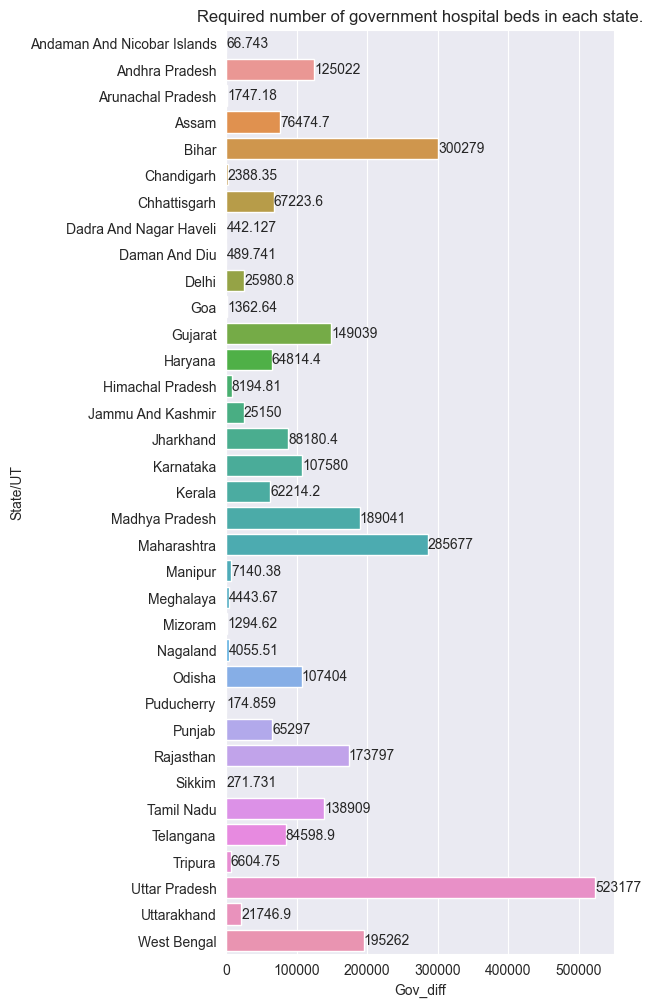

In [278]:
plt.figure(figsize=(5,12))
# plt.vlines(x = 6.112648, ymin = -1, ymax = 38, color = 'black', linewidth=0.8)
ax = sns.barplot(data=hosp_gov_who[hosp_gov_who['Gov_diff']>0], y='State/UT', x='Gov_diff')
plt.title('Required number of government hospital beds in each state.')
ax.bar_label(ax.containers[0])
plt.show()


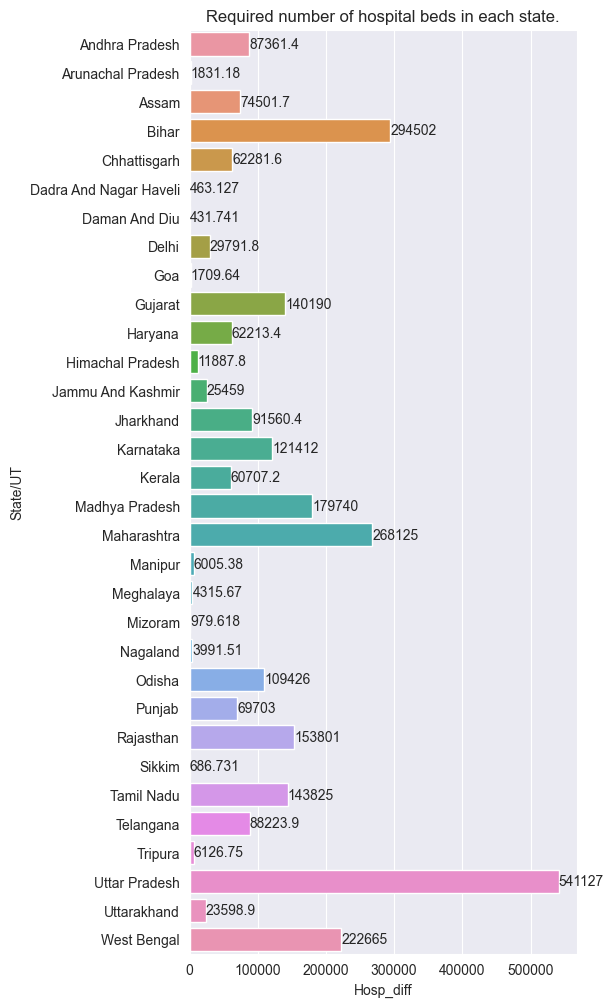

In [279]:
plt.figure(figsize=(5,12))
# plt.vlines(x = 6.112648, ymin = -1, ymax = 38, color = 'black', linewidth=0.8)
ax = sns.barplot(data=hosp_gov_who[hosp_gov_who['Hosp_diff']>0].drop(36), y='State/UT', x='Hosp_diff')
plt.title('Required number of hospital beds in each state.')
ax.bar_label(ax.containers[0])
plt.show()


#### Problem Statement 17: (Hospitals required to meet the standards)

In [282]:
hosp_gov_who.head(2)

,State/UT,Population,HospitalBeds,Total_Gov_Beds,Total_Hosps,WHO_beds,Gov_diff,Hosp_diff
0,Andaman And Nicobar Islands,380581.0,1246.0,1075.0,30.0,1141.743,66.743,-104.257
1,Andhra Pradesh,49386799.0,60799.0,23138.0,258.0,148160.397,125022.397,87361.397


In [283]:
hosp_gov_who['Hosps_need'] = (hosp_gov_who['Gov_diff'] * hosp_gov_who['Total_Hosps'])/ hosp_gov_who['Total_Gov_Beds']
hosp_gov_who


,State/UT,Population,HospitalBeds,Total_Gov_Beds,Total_Hosps,WHO_beds,Gov_diff,Hosp_diff,Hosps_need
0,Andaman And Nicobar Islands,3.805810e+05,1246.0,1075.0,30.0,1141.743,66.743,-104.257,1.862595
1,Andhra Pradesh,4.938680e+07,60799.0,23138.0,258.0,148160.397,125022.397,87361.397,1394.060784
2,Arunachal Pradesh,1.383727e+06,2320.0,2404.0,218.0,4151.181,1747.181,1831.181,158.438210
3,Assam,3.120558e+07,19115.0,17142.0,1226.0,93616.728,76474.728,74501.728,5469.491105
4,Bihar,1.040995e+08,17796.0,12019.0,1033.0,312298.356,300279.356,294502.356,25808.184936
5,Chandigarh,1.055450e+06,3756.0,778.0,4.0,3166.350,2388.350,-589.650,12.279434
6,Chhattisgarh,2.554520e+07,14354.0,9412.0,214.0,76635.594,67223.594,62281.594,1528.458257
7,Dadra And Nagar Haveli,3.437090e+05,568.0,589.0,11.0,1031.127,442.127,463.127,8.257041
8,Daman And Diu,2.432470e+05,298.0,240.0,5.0,729.741,489.741,431.741,10.202937
9,Delhi,1.678794e+07,20572.0,24383.0,109.0,50363.823,25980.823,29791.823,116.142792


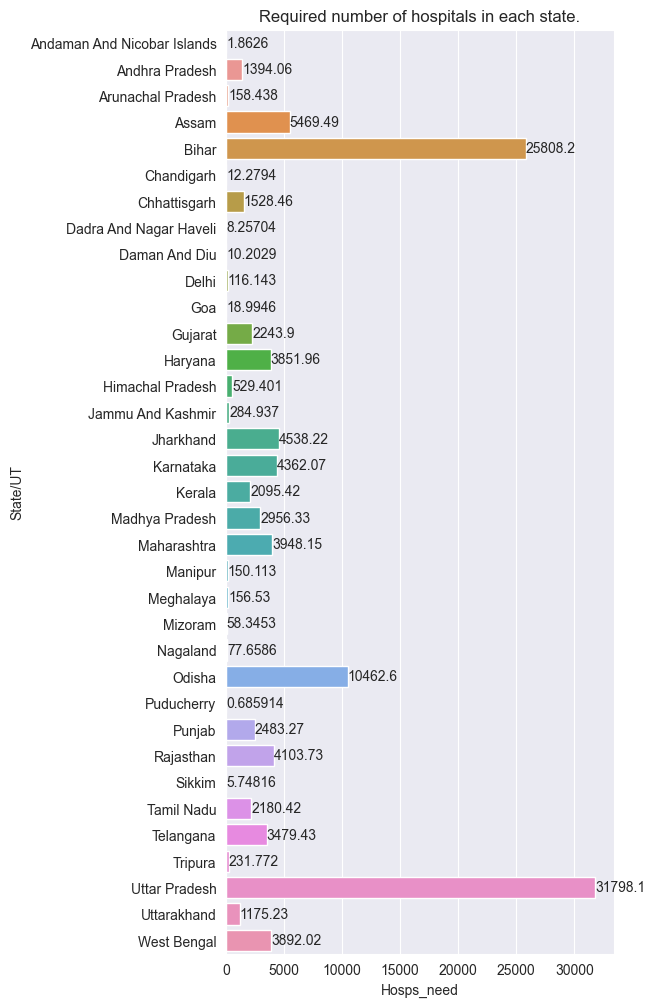

In [284]:
plt.figure(figsize=(5,12))
# plt.vlines(x = 6.112648, ymin = -1, ymax = 38, color = 'black', linewidth=0.8)
ax = sns.barplot(data=hosp_gov_who[hosp_gov_who['Hosps_need']>0], y='State/UT', x='Hosps_need')
plt.title('Required number of hospitals in each state.')
ax.bar_label(ax.containers[0])
plt.show()


### Test functions

In [ ]:
housing.df['State/UT'].unique()

array(['Jammu And Kashmir', 'Laddakh', 'Himachal Pradesh', 'Punjab',
       'Chandigarh', 'Uttarakhand', 'Haryana', 'Delhi', 'Rajasthan',
       'Uttar Pradesh', 'Bihar', 'Sikkim', 'Arunachal Pradesh',
       'Nagaland', 'Manipur', 'Mizoram', 'Tripura', 'Meghalaya', 'Assam',
       'West Bengal', 'Jharkhand', 'Odisha', 'Chhattisgarh',
       'Madhya Pradesh', 'Gujarat', 'Daman And Diu',
       'Dadra And Nagar Haveli', 'Maharashtra', 'Telangana',
       'Andhra Pradesh', 'Karnataka', 'Goa', 'Lakshadweep', 'Kerala',
       'Tamil Nadu', 'Puducherry', 'Andaman And Nicobar Islands'],
      dtype=object)

In [ ]:
test[test['District']=='Bijapur']

,State/UT,District,Rural/Urban,Total Number of households,Total Number of Livable,Total Number of Dilapidated,Latrine_premise
1243,Chhattisgarh,Bijapur,Rural,100,56.5,4.2,2.7
1244,Chhattisgarh,Bijapur,Total,100,57.0,4.1,5.6
1245,Chhattisgarh,Bijapur,Urban,100,61.2,3.1,28.1
1660,Karnataka,Bijapur,Rural,100,41.7,6.8,5.0
1661,Karnataka,Bijapur,Total,100,38.3,5.9,18.1
1662,Karnataka,Bijapur,Urban,100,27.7,2.9,59.5


In [ ]:
merged_df[merged_df['District']=='Bijapur']


,State/UT,District,Households,Total Number of households_Rural,Total Number of households_Total,Total Number of households_Urban,Total Number of Livable_Rural,Total Number of Livable_Total,Total Number of Livable_Urban,Total Number of Dilapidated_Rural,Total Number of Dilapidated_Total,Total Number of Dilapidated_Urban,Latrine_premise_Rural,Latrine_premise_Total,Latrine_premise_Urban
416,Chhattisgarh,Bijapur,58391.0,100.0,100.0,100.0,56.5,57.0,61.2,4.2,4.1,3.1,2.7,5.6,28.1
556,Karnataka,Bijapur,527490.0,100.0,100.0,100.0,41.7,38.3,27.7,6.8,5.9,2.9,5.0,18.1,59.5


In [ ]:
def modify_state(x):
    '''Modifies and adds uniformity to State/UT column values.'''

    x = x.split(' ')
    s = ''
    for l in x:
        if l.lower() != 'and':
            s += ' ' + l.capitalize()
        else:
            s+= ' ' + l.lower() 
    return s.strip()

test = census_df['State/UT'].apply(modify_state)
# test 

In [ ]:
census_df = census_df.replace('ORISSA', 'Odisha', regex=False)
census_df['State/UT'].unique()

array(['Jammu and Kashmir', 'Laddakh', 'Himachal Pradesh', 'Punjab',
       'Chandigarh', 'Uttarakhand', 'Haryana', 'Delhi', 'Rajasthan',
       'Uttar Pradesh', 'Bihar', 'Sikkim', 'Arunachal Pradesh',
       'Nagaland', 'Manipur', 'Mizoram', 'Tripura', 'Meghalaya', 'Assam',
       'West Bengal', 'Jharkhand', 'Odisha', 'Chhattisgarh',
       'Madhya Pradesh', 'Gujarat', 'Daman and Diu',
       'Dadra and Nagar Haveli', 'Maharashtra', 'Telangana',
       'Andhra Pradesh', 'Karnataka', 'Goa', 'Lakshadweep', 'Kerala',
       'Tamil Nadu', 'Puducherry', 'Andaman and Nicobar Islands'],
      dtype=object)

In [ ]:
def null_percent(df):
    null_percents = df.isnull().sum() * 100 / len(df)
    null_percents = null_percents.reset_index()
    null_percents.columns = ['Columns', 'Null_Percent']
    null_percents = null_percents.sort_values(by=['Null_Percent'], ascending=False)
    return null_percents

In [ ]:
def fill_nulls(df, total, rest_cols):
    df[total] = df[total].fillna(df[rest_cols].sum(axis=1, skipna=False))
    for col in rest_cols:
        copy_cols = [c for c in rest_cols if c != col]
        df[col] = df[col].fillna(df[total]-df[copy_cols].sum(axis=1, skipna=False))

In [ ]:
censustest = census.df.copy()
housingtest = housing.df.copy()

In [ ]:
# merged_df = pd.merge(censustest[['State/UT','Households', 'District']], housingtest,  how='left', left_on='District', right_on='District Name')
# merged_df

In [ ]:
# missing_districts = merged_df.loc[merged_df['District Name'].isnull(), 'District'].tolist()
# missing_districts

In [ ]:
# cols = ['Total Number of households', 'Total Number of Livable', 'Total Number of Dilapidated', 'Latrine_premise']
# def absolute(df, cols):
#     for col in cols:
#         df[col] = df[col] * df['Households'] / 100
    
#     return df


In [ ]:
# testing_absolute = absolute(merged_df, cols)
# testing_absolute